In [118]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite2d_vrel'
run_name = 'nac_long4'
data_dir = '../data/'+system_name+'/'+run_name+'/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

# Learning of the 2d kite with a non-constant wind
- The aggregate state is the discretized attack angle and the angle with the relative valocity
- The wind velocity is based on a simple stream-function
- The initial angle with the ground, $\theta$, is constant
- The initial attack angle can be choosen constant or random
- The algortihm is a natural actor-critic with advantage parameters. It uses two power law learning rates (the one of the critic part should be much larger) having a burn-in period in which it stays constant (see the first plot of the learning rates)

## Setting the parameters

In [121]:
# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.0005 # sec
env_params['ep_length'] = 200 # sec
env_params['decision_time'] = 0.1 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
# attack angles
env_params['alphas'] = [-4, 0, 4, 8, 12, 14, 16, 18, 20]
env_params['CL_alphas'] = [0.05, 0.35, 0.55, 0.75, 0.9, 1.0, 1.08, 1.1, 1.05]
env_params['CD_alphas'] = [0.001, 0.01, 0.03, 0.07, 0.1, 0.13, 0.18, 0.18, 0.21]
env_params['init_alpha'] = len(env_params['alphas'])-1 # index, if larger than len it's random
env_params['beta_bins'] = [-np.pi, -3.08, -3.0, -2.9, -2.7, -2.4, -2.1, -1.8, -1.5,-1.2, -0.9, -0.6, -0.3, 0., \
                           0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 2.9, 3.0, 3.08, np.pi]
print('Beta bins: ', np.rad2deg(env_params['beta_bins']))
# wind
env_params['wind_type'] = 'stream'
env_params['k_wind'] = 0.5 # 1/sec
env_params['eps_wind'] = 0.2

# ALG PARAMETERS
alg_params = dict()
alg_params['alg_type'] = 'nac' # 'ac' for actor-critic, 'nac' for natural actor-critic
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 20000000
print('Dynamical steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Dynamical time, in seconds: ', alg_params['n_steps']*env_params['decision_time'])
alg_params['traj_points'] = 1000

alg_params['init_val_path'] = '../data/'+system_name+'/nac_long3/best_value.txt' # Value prior, comment for constant values
alg_params['init_pol_path'] = '../data/'+system_name+'/nac_long3/best_policy.txt' # Policy prior, comment for flat policy
alg_params['init_values'] = 500

# Actor learning rate
alg_params['a0'] = 0.0005
alg_params['ac'] = 3000000
alg_params['a_expn'] = 1
alg_params['a_burn'] = 5000000
# Critic learning rate
alg_params['b0'] = 0.0000005
alg_params['bc'] = 50
alg_params['b_expn'] = 0.8
alg_params['b_burn'] = alg_params['n_steps']

Beta bins:  [-180.         -176.4710009  -171.88733854 -166.15776059 -154.69860469
 -137.50987083 -120.32113698 -103.13240312  -85.94366927  -68.75493542
  -51.56620156  -34.37746771  -17.18873385    0.           17.18873385
   34.37746771   51.56620156   68.75493542   85.94366927  103.13240312
  120.32113698  137.50987083  154.69860469  166.15776059  171.88733854
  176.4710009   180.        ]
Dynamical steps:  4000000000.0
Dynamical time, in seconds:  2000000.0


In [122]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")

## Training analysis

### Learning rate scheduling

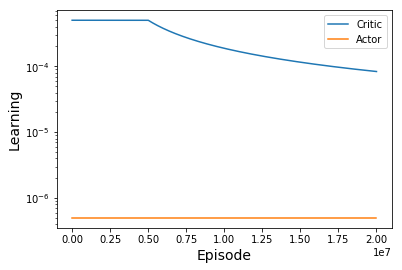

In [124]:
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Learning', fontsize=14)
plt.yscale('log')
xs = np.linspace(0, alg_params['n_steps'], alg_params['traj_points'])
crit_lr = [ut.p_law_burn(x, alg_params['a_burn'], alg_params['a_expn'], alg_params['a0'], alg_params['ac']) for x in xs]
act_lr = [ut.p_law_burn(x, alg_params['b_burn'], alg_params['b_expn'], alg_params['b0'], alg_params['bc']) for x in xs]

plt.plot(xs, crit_lr, label='Critic')
plt.plot(xs, act_lr, label='Actor')
plt.legend()

plt.savefig(plot_dir+'lr.png', dpi=200)

In [125]:
import numpy as np
v_traj, s_labels = ut.read_traj(data_dir + 'value_traj.txt')
r_traj, head = ut.read_traj(data_dir + 'return_traj.txt')

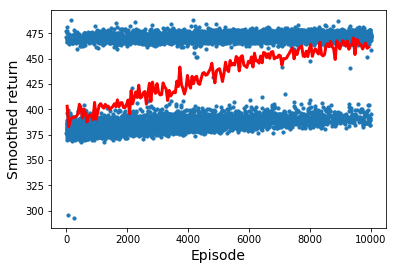

In [126]:
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Smoothed return', fontsize=14)
x, y = ut.smooth_traj(r_traj[:,0], 1)
plt.scatter(x,y,s=10)
x, y = ut.smooth_traj(r_traj[:,0], 50)
plt.plot(x,y, color='red', lw=3)

plt.savefig(plot_dir+'return.png', dpi=200)

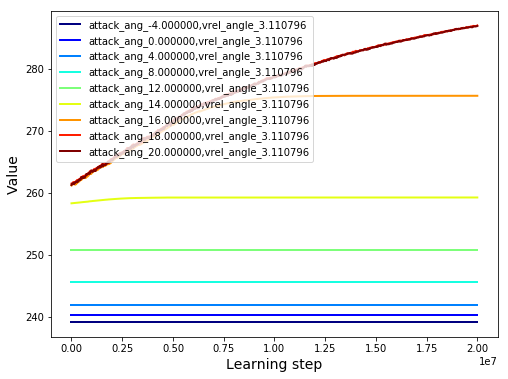

In [139]:
#val_fig_name='alp=18'
n_alphas=len(env_params['alphas'])
n_betas=len(env_params['beta_bins'])-1
#alpha = n_alphas-5
alphas = np.arange(n_alphas)
#betas = np.arange(n_betas)
beta = 25
xs = np.linspace(0, alg_params['n_steps'], alg_params['traj_points'])

colors = plt.cm.jet(np.linspace(0,1,len(alphas)))
plt.figure(figsize=(8,6))
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Value', fontsize=14)
count=0

for a in alphas:
    index = beta+a*n_betas
    plt.plot(xs, v_traj[:,index], lw=2, label=s_labels[index], c=colors[count])
    count+=1

plt.legend(loc=2)
plt.savefig(plot_dir+'values_b='+str(beta)+'.png', dpi=200)

In [140]:
p_traj, s_labels, a_labels = ut.read_2d_traj(data_dir + "policy_traj.txt")

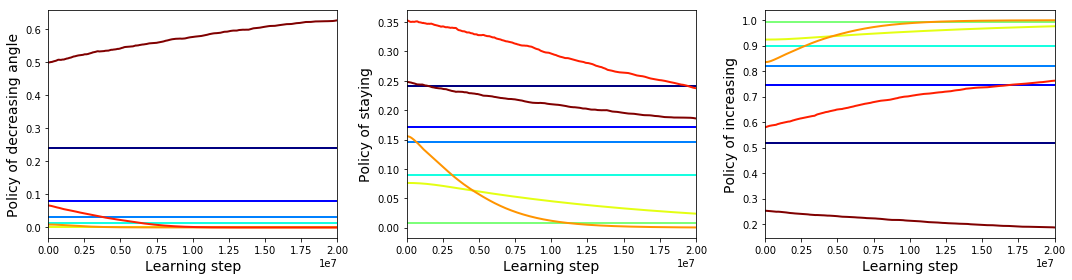

In [141]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
colors = plt.cm.jet(np.linspace(0,1,len(alphas)))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Policy of decreasing angle', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for a in alphas:
    index = beta+a*n_betas
    ax1.plot(xs, p_traj[:,index,0], c=colors[count], label=s_labels[index], lw=2)
    count += 1
#ax1.legend()

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Policy of staying', fontsize=14)
ax2.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for a in alphas:
    index = beta+a*n_betas
    ax2.plot(xs, p_traj[:,index,1], c=colors[count], lw=2)
    count += 1

ax3.set_xlabel('Learning step', fontsize=14)
ax3.set_ylabel('Policy of increasing', fontsize=14)
ax3.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for a in alphas:
    index = beta+a*n_betas
    ax3.plot(xs, p_traj[:,index,2], c=colors[count], lw=2)
    count += 1
    
plt.tight_layout()
plt.savefig(plot_dir+'policy_b='+str(beta)+'.png', dpi=200)